---
title: 'Processing I: Motion tracking and balance'
---

In the previous notebook, we have ran pose estimation on the trial videos (OpenPose), and triangulated the coordinates to get 3D coordinates for each trial (Pose2sim). Furthermore, we have performed inverse kinematics and dynamics to extract joint angles and moments (OpenSim).

In this script, we will clean the data, and extract further information (such as speed, acceleration, etc.). 

In [1]:
#| code-fold: true
#| code-summary: Code to load packages and prepare the environment

# packages
import os
import glob
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import scipy
import random



curfolder = os.getcwd()

# files to work with
MTfolder = curfolder + '\\..\\02_MotionTracking_processing\\projectdata\\' ## FLAGGED CHANGE
BBfolder = curfolder + '\\..\\01_XDF_processing\\data\\Data_processed\\Data_trials\\'

# folders to save the processed data
MTfolder_processed = curfolder + '\\TS_motiontracking\\'

# Motion processing - kinematics

Here we use the keypoint coordinates estimated via OpenPose (@ADDREF) and triangulated via Pose2Sim (@ADDREF). While Pose2sim does provie in-built filter, it is not particularly strong and the data can be still noisy.

To decide on the smoothing strength, we can use a custom function `check_smooth_strength` to check the effect of different smoothing strengths on the data. 



In [2]:
#| code-fold: true
#| code-summary: Code to prepare files to process

MTtotrack = glob.glob(MTfolder + '*/P*/*', recursive=True)

# get rid of all the folders that are not the ones we want to track, like .sto files
    ## FLAG! why not do glob.glob(MTfolder + '*/P*/*butterworth*.csv', recursive=True)
MTtotrack = [x for x in MTtotrack if 'sto' not in x]
MTtotrack = [x for x in MTtotrack if 'txt' not in x]
MTtotrack = [x for x in MTtotrack if 'xml' not in x]
MTtotrack = [x for x in MTtotrack if 'opensim' not in x]
MTtotrack = [x for x in MTtotrack if 'Results' not in x]
MTtotrack = [x for x in MTtotrack if 'toml' not in x]

print(MTtotrack[1:10])

MTfiles_all = []

for folder in MTtotrack:
    # last element is trialid
    trialid = folder.split('\\')[-1]
    
    # get all csv files in the folder
    csvfiles = glob.glob(folder + '\\**\\*.csv', recursive=True)
    # keep only the ones that have butterworth in the name - those are filtered with native Pose2sim function
    csvfiles = [x for x in csvfiles if 'butterworth' in x]
    butterfile = csvfiles[0]
    # append to list with trialid
    MTfiles_all.append([trialid, butterfile])

[]


In [26]:
#| code-fold: false
#| code-summary: Code with function to check smoothing strength

# function to check different smoothing windows and orders
def check_smooth_strength(df, windows, orders, keytoplot):

    # prepare new df
    df_smooth = pd.DataFrame()

    for win in windows:
        for ord in orders:
            df_smooth[keytoplot + '_savgol' + str(win) + '_' + str(ord)] = scipy.signal.savgol_filter(df[keytoplot], win, ord)

    # make R_Hand_x from df_sample a list
    keytoplot_unsmoothed = df[keytoplot].tolist()

    # load these values into df_smooth as a new column
    df_smooth[keytoplot] = keytoplot_unsmoothed

    # plot keytoplot in all strngths
    colstoplot = [x for x in df_smooth.columns if keytoplot in x]
    plt.figure()
    for col in colstoplot:
        plt.plot(df_smooth[col], label=col)
    plt.legend()
    plt.show()

Here we can see a timeseries of vertical dimension of the left knee. Each color represents the timeseries in different smoothed version, pink one is the raw signal (which is smoothed only with the Butterworth 10Hz cut-off filter). The first number in the legend corresponds to window length and the second number to polynomial order.

e:\FLESH_ContinuousBodilyEffort\03_TS_processing\..\02_MotionTracking_processing\projectdata\Session_0_1\P0\0_1_41_p0\pose-3d\0_1_41_p0_0-364_filt_butterworth.trc.csv


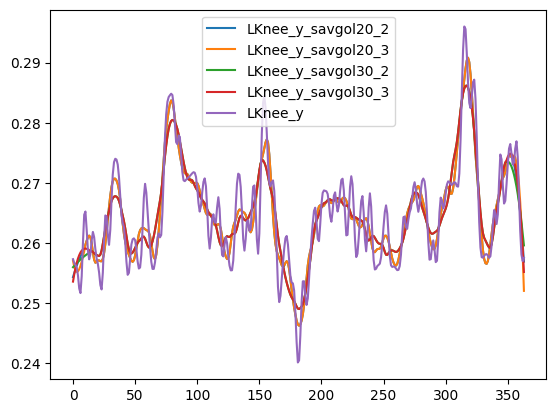

In [30]:
#| echo: false

print(MTfiles_all[20][1])
sample = pd.read_csv(MTfiles_all[20][1], sep=',')

windows = [20, 30] # list possible window
orders = [2, 3] # list possible orders

check_smooth_strength(sample, windows, orders, 'LKnee_y')

Here we can see the same thing for wrist.

e:\FLESH_ContinuousBodilyEffort\03_TS_processing\..\02_MotionTracking_processing\projectdata\Session_0_1\P0\0_1_41_p0\pose-3d\0_1_41_p0_0-364_filt_butterworth.trc.csv


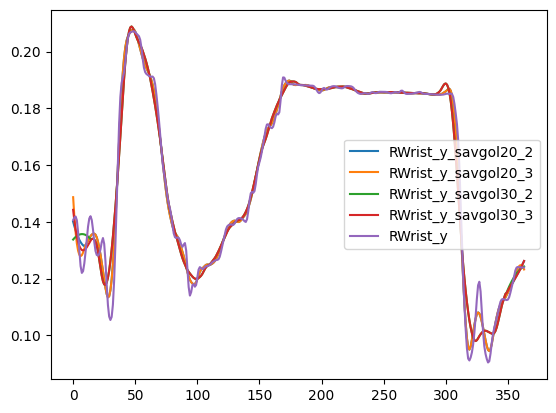

In [29]:
#| echo: false

print(MTfiles_all[20][1])
sample = pd.read_csv(MTfiles_all[20][1], sep=',')

windows = [20, 30] # list possible window
orders = [2, 3] # list possible orders

check_smooth_strength(sample, windows, orders, 'RWrist_y')

For both, 3rd order Savitzky-Golay filter with window of 320 ms seems to be a good choice. We will use it both for raw coordinates as well as for the derivatives.

Further, we obtain the first, second and third derivative of the timeseries, namely speed, acceleration, and jerk. 

Lastly, to be able to work with timeseries that represent bigger segment of body than a single joint, we aggregate the kinematic derivatives for each body group (i.e., head, upperbody, arms, lowerbody) by computing euclidian sum over every derivative belonging to the group. This gives us, for instance, a measure for arm speed that represents a sum of speeds of all keypoints associated with the arm (i.e., wrist, elbow, shoulder, index)

In [44]:
#| code-fold: true
#| code-summary: Code with functions for processing kinematic data

# function to get euclidian sum of associated keypoints
def aggregate_keypoints(df, measurement, finalcolname, use):

    if use == 'kinematics':
        # group keypoints that belong together
        lowerbodycols = ['RHip', 'LHip']
        legcols = ['RKnee', 'RAnkle', 'LAnkle', 'LKnee', 'RHeel', 'LHeel']
        headcols = ['Head', 'Neck', 'Nose']
        armcols = ['RShoulder', 'RElbow', 'RWrist', 'LShoulder', 'LElbow', 'LWrist', 'RIndex', 'LIndex']

        groups = [lowerbodycols, legcols, headcols, armcols]

    elif use == 'angles':
        pelviscols = ['pelvis']
        spinecols = ['L5_S1', 'L4_L5', 'L3_L4', 'L2_L3', 'L1_L2', 'L1_T12']
        lowerbodycols = ['pelvis', 'hip']
        legcols = ['knee', 'ankle', 'subtalar']
        headcols = ['neck']
        armcols = ['arm', 'elbow', 'wrist', 'pro_sup']

        groups = [lowerbodycols, legcols, headcols, armcols, pelviscols, spinecols]

    # make subdf only with speed
    subdf = df[[x for x in df.columns if measurement in x]]

    # loop through each joint group
    for group in groups:
        # get cols
        cols = [x for x in subdf.columns if any(y in x for y in group)]
        subdf_temp = subdf[cols]

        for index, row in subdf_temp.iterrows():
            # get all values of that row
            values = row.values
            # calculate euclidian sum
            euclidian_sum = np.sqrt(np.sum(np.square(values))) ## FLAGGED: possibly normalize
            # get a name for new col
            if group == lowerbodycols:
                colname = 'lowerbody'
            elif group == legcols:
                colname = 'leg'
            elif group == headcols:
                colname = 'head'
            elif group == armcols:
                colname = 'arm'
            elif group == pelviscols:
                colname = 'pelvis'
            elif group == spinecols:
                colname = 'spine'
                

            df.loc[index, colname + finalcolname] = euclidian_sum

    return df


# get kinematic derivatives
def get_derivatives(df, sr, upperbodycols, lowerbodycols, use):

    mtcols = df.columns
    if use == 'kinematics':
        # get rid of cols that are not x, y or z
        mtcols = [x for x in mtcols if '_x' in x or '_y' in x or '_z' in x]
    

        # prepare cols for speed
        cols = [x.split('_')[0] for x in mtcols]
        colsforspeed = list(set(cols))

        # for each unique colname (cols), calculate speed 
        for col in colsforspeed:
            # get x and y columns
            x = df[col + '_x']
            y = df[col + '_y']
            z = df[col + '_z'] # note that y and z are flipped
            # calculate speed
            speed = np.insert(np.sqrt(np.diff(x)**2 + np.diff(y)**2 + np.diff(z)**2),0,0)
            # multiply the values by sr, because now we have values in m/(s/sr)
            speed = speed*sr

            # smooth
            speed = scipy.signal.savgol_filter(speed, 20, 3)

            # if the col contains wrist, we will alco calculate the vertical velocity (z dimension)
            if 'Wrist' in col:
                verticvel = np.insert(np.diff(z), 0, 0)
                verticvel = verticvel*sr
                verticvel = scipy.signal.savgol_filter(verticvel, 20, 3)

            # derive acceleration	
            acceleration = np.insert(np.diff(speed), 0, 0)
            acceleration = scipy.signal.savgol_filter(acceleration, 20, 3)

            # derive jerk
            jerk = np.insert(np.diff(acceleration), 0, 0)
            jerk = scipy.signal.savgol_filter(jerk, 20, 3)

            # new_data
            new_data = pd.DataFrame({col + '_speed': speed, col + '_acc': acceleration, col + '_jerk': jerk})
            df = pd.concat([df, new_data], axis=1)

    elif use == 'angles':
        # get rid of cols that are not angles (so skip time)
        mtcols = mtcols[1:]

        # derive speed
        for col in mtcols:
            speed = np.insert(np.diff(df[col]), 0, 0)
            speed = speed*sr
            speed = scipy.signal.savgol_filter(speed, 20, 3)

            # derive acceleration
            acceleration = np.insert(np.diff(speed), 0, 0)
            acceleration = scipy.signal.savgol_filter(acceleration, 20, 3)
            
            # derive jerk
            jerk = np.insert(np.diff(acceleration), 0, 0)
            jerk = scipy.signal.savgol_filter(jerk, 20, 3)

            # new_data
            new_data = pd.DataFrame({col + '_speed': speed, col + '_acc': acceleration, col + '_jerk': jerk})
            df = pd.concat([df, new_data], axis=1)

    return df

In [ ]:
#| code-fold: false
#| eval: false

# upper body cols
upperbodycols = ['Head', 'Neck', 'RShoulder', 'RElbow', 'RWrist', 'LShoulder', 'LElbow', 'LWrist', 'Nose', 'RIndex', 'LIndex']
# lower body cols
lowerbodycols = ['RHip', 'RKnee', 'RAnkle', 'RHeel' 'LHip', 'LKnee', 'LAnkle', 'LHeel']

for folder in MTtotrack:
    # last element is trialid
    trialid = folder.split('\\')[-1]
    print('working on:' + trialid)
    
    # get all csv files in the folder
    csvfiles = glob.glob(folder + '/**/*.csv', recursive=True)
    # keep only the ones that have butterworth in the name
    csvfiles = [x for x in csvfiles if 'butterworth' in x]
    butterfile = csvfiles[0]

    # load it
    mt = pd.read_csv(butterfile)

    # the mt is missing 0 ms timepoint, so we need to create a row that copies the first row of mt and time = 0
    padrow = mt.iloc[0].copy()
    padrow['Time'] = 0

    # concatenate it to the beginning of mt 
    mt = pd.concat([pd.DataFrame(padrow).T, mt], ignore_index=True)

    # keep only cols of interest
    colstokeep = ["Time", "RHip", "RKnee", "RAnkle", "RHeel", "LHip", "LKnee", "LAnkle", "LHeel", "Neck", "Head", "Nose", "RShoulder", "RElbow", "RWrist", "RIndex", "LShoulder", "LElbow", "LWrist",
    "LIndex",
]
    mt = mt[[col for col in mt.columns if any(x in col for x in colstokeep)]]

    # flip y and z dimension as they are reversed from OpenPose/Pose2sim

    # if col has _y in it, replace it by _temp
    mt.columns = [x.replace('_y', '_temp') for x in mt.columns]
    # replace _z by _y
    mt.columns = [x.replace('_z', '_y') for x in mt.columns]
    # replace _temp by _z
    mt.columns = [x.replace('_temp', '_z') for x in mt.columns]

    ####### SMOOTHING ######

    # smooth all columns except time with savgol
    mtcols = mt.columns
    colstosmooth = mtcols[:-1]

    mt_smooth = pd.DataFrame()

    for col in colstosmooth:
        mt_smooth[col] = scipy.signal.savgol_filter(mt[col], 20, 3)
        # alternatively, it is possible to smooth lower and upper body with differently strong filter - we do not use it here though, as 20,3 filter seems to work well
        # # if the col belongs to upperbody, smooth with 15,1
        # if any(x in col for x in upperbodycols):
        #     mt_smooth[col] = scipy.signal.savgol_filter(mt[col], 15, 1)
        # # as the lowerbody keypoints are not moving that much, they are much more prone to noise (e.g., from the measurement error of OpenPose, therefore we will smooth them with a little higher window)
        # elif any(x in col for x in lowerbodycols):
        #     mt_smooth[col] = scipy.signal.savgol_filter(mt[col], 20, 1)
        # else:
        #     mt_smooth[col] = scipy.signal.savgol_filter(mt[col], 15, 1)

        # and put them all to cms
        mt_smooth[col] = mt_smooth[col]*100

    # add back time column
    mt_smooth['Time'] = mt['Time']

    # get sampling rate
    sr = 1/np.mean(np.diff(mt['Time']))

    ###### DERIVATIVES ######

    # get kinematic derivatives
    mt_smooth = get_derivatives(mt_smooth, sr, upperbodycols, lowerbodycols, 'kinematics')

    ###### AGGREGATING ######

    # getting aggreagated sums for groups of cols
    mt_smooth = aggregate_keypoints(mt_smooth, 'speed', '_speedKin_sum', 'kinematics')
    mt_smooth = aggregate_keypoints(mt_smooth, 'acc', '_accKin_sum', 'kinematics')
    mt_smooth = aggregate_keypoints(mt_smooth, 'jerk', '_jerkKin_sum', 'kinematics')

    # add trialid
    mt_smooth['TrialID'] = trialid
    # convert time to ms
    mt_smooth['Time'] = mt_smooth['Time']*1000
    # write to csv
    mt_smooth.to_csv(MTfolder_processed + '/mt_' + trialid + '.csv', index=False)

working on:e:\FLESH_ContinuousBodilyEffort\03_TS_processing\..\02_MotionTracking_processing\projectdata\Session_0_1\P0\0_1_tpose_p0
working on:e:\FLESH_ContinuousBodilyEffort\03_TS_processing\..\02_MotionTracking_processing\projectdata\Session_0_1\P0\0_1_0_p0
working on:e:\FLESH_ContinuousBodilyEffort\03_TS_processing\..\02_MotionTracking_processing\projectdata\Session_0_1\P0\0_1_3_p0
working on:e:\FLESH_ContinuousBodilyEffort\03_TS_processing\..\02_MotionTracking_processing\projectdata\Session_0_1\P0\0_1_4_p0
working on:e:\FLESH_ContinuousBodilyEffort\03_TS_processing\..\02_MotionTracking_processing\projectdata\Session_0_1\P0\0_1_5_p0
working on:e:\FLESH_ContinuousBodilyEffort\03_TS_processing\..\02_MotionTracking_processing\projectdata\Session_0_1\P0\0_1_6_p0
working on:e:\FLESH_ContinuousBodilyEffort\03_TS_processing\..\02_MotionTracking_processing\projectdata\Session_0_1\P0\0_1_7_p0
working on:e:\FLESH_ContinuousBodilyEffort\03_TS_processing\..\02_MotionTracking_processing\projectd

Here is an example of the file

In [ ]:
#| echo: false

mtfiles = glob.glob(MTfolder_processed + '*.csv')
# Keep only mt_
mtfiles = [x for x in mtfiles if 'mt_' in x]
mtfile = random.choice(mtfiles)

# Display
mt = pd.read_csv(mtfile)
mt.head(15)

,RHip_x,RHip_z,RHip_y,RKnee_x,RKnee_z,RKnee_y,RAnkle_x,RAnkle_z,RAnkle_y,RHeel_x,...,arm_speedKin_sum,lowerbody_accKin_sum,leg_accKin_sum,head_accKin_sum,arm_accKin_sum,lowerbody_jerkKin_sum,leg_jerkKin_sum,head_jerkKin_sum,arm_jerkKin_sum,TrialID
0,11.561312,24.262533,1.893774,12.797520,27.842546,-41.546159,14.581866,26.512210,-78.872951,17.834685,...,16.715121,0.386914,0.387236,0.137296,0.707989,0.057146,0.029496,0.033653,0.121305,0_2_7_p0
1,11.552714,24.289893,1.834511,12.798423,27.841630,-41.553415,14.568615,26.557129,-78.909880,17.770652,...,16.673992,0.396442,0.385447,0.110105,0.586689,0.058050,0.028146,0.033118,0.135296,0_2_7_p0
2,11.544115,24.317253,1.775248,12.799327,27.840715,-41.560671,14.555364,26.602048,-78.946809,17.706619,...,16.660467,0.418229,0.385827,0.089789,0.524892,0.059015,0.026854,0.032639,0.151807,0_2_7_p0
3,11.535516,24.344613,1.715985,12.800231,27.839799,-41.567927,14.542113,26.646968,-78.983738,17.642586,...,16.674614,0.450499,0.388370,0.081653,0.543295,0.060038,0.025630,0.032216,0.170107,0_2_7_p0
4,11.526917,24.371973,1.656723,12.801134,27.838884,-41.575183,14.528862,26.691887,-79.020666,17.578554,...,16.716363,0.491191,0.393032,0.089099,0.634964,0.061115,0.024482,0.031854,0.189678,0_2_7_p0
5,11.518319,24.399333,1.597460,12.802038,27.837969,-41.582439,14.515610,26.736806,-79.057595,17.514521,...,16.785508,0.538399,0.399741,0.108978,0.774299,0.062243,0.023422,0.031554,0.210166,0_2_7_p0
6,11.509720,24.426693,1.538197,12.802941,27.837053,-41.589695,14.502359,26.781725,-79.094524,17.450488,...,16.881711,0.590561,0.408395,0.135941,0.940346,0.063421,0.022463,0.031317,0.231327,0_2_7_p0
7,11.501121,24.454054,1.478934,12.803845,27.836138,-41.596951,14.489108,26.826645,-79.131453,17.386455,...,17.004514,0.646480,0.418874,0.166583,1.121299,0.064645,0.021617,0.031145,0.252993,0_2_7_p0
8,11.492523,24.481414,1.419671,12.804749,27.835222,-41.604207,14.475857,26.871564,-79.168381,17.306910,...,18.661366,0.724951,0.447395,0.205911,1.338565,0.067151,0.020947,0.032031,0.280315,0_2_7_p0
9,11.483924,24.508774,1.360408,12.805652,27.834307,-41.611463,14.462606,26.916483,-79.205310,17.226529,...,19.185882,0.769077,0.449252,0.246023,1.557322,0.061742,0.018756,0.032257,0.287566,0_2_7_p0


Let's check one file to see how the data looks like by plotting RWrist and its kinematics, and also the euclidian sum for the whole arm along with it (as dashed black line)

Note that aggregates will always be directionless (i.e., in positive numbers) as they are squared when computed.


['e:\\FLESH_ContinuousBodilyEffort\\03_TS_processing\\TS_motiontracking\\mt_0_1_0_p0.csv', 'e:\\FLESH_ContinuousBodilyEffort\\03_TS_processing\\TS_motiontracking\\mt_0_1_18_p0.csv', 'e:\\FLESH_ContinuousBodilyEffort\\03_TS_processing\\TS_motiontracking\\mt_0_1_19_p0.csv', 'e:\\FLESH_ContinuousBodilyEffort\\03_TS_processing\\TS_motiontracking\\mt_0_1_1_p0.csv', 'e:\\FLESH_ContinuousBodilyEffort\\03_TS_processing\\TS_motiontracking\\mt_0_1_20_p0.csv', 'e:\\FLESH_ContinuousBodilyEffort\\03_TS_processing\\TS_motiontracking\\mt_0_1_21_p0.csv', 'e:\\FLESH_ContinuousBodilyEffort\\03_TS_processing\\TS_motiontracking\\mt_0_1_22_p0.csv', 'e:\\FLESH_ContinuousBodilyEffort\\03_TS_processing\\TS_motiontracking\\mt_0_1_23_p0.csv', 'e:\\FLESH_ContinuousBodilyEffort\\03_TS_processing\\TS_motiontracking\\mt_0_1_24_p0.csv', 'e:\\FLESH_ContinuousBodilyEffort\\03_TS_processing\\TS_motiontracking\\mt_0_1_25_p0.csv', 'e:\\FLESH_ContinuousBodilyEffort\\03_TS_processing\\TS_motiontracking\\mt_0_1_26_p0.csv', 

C:\Users\kadava\AppData\Local\Temp\ipykernel_13044\365927481.py:52: UserWarning: This figure was using a layout engine that is incompatible with subplots_adjust and/or tight_layout; not calling subplots_adjust.
  plt.subplots_adjust(hspace=0.3, wspace=0.3)


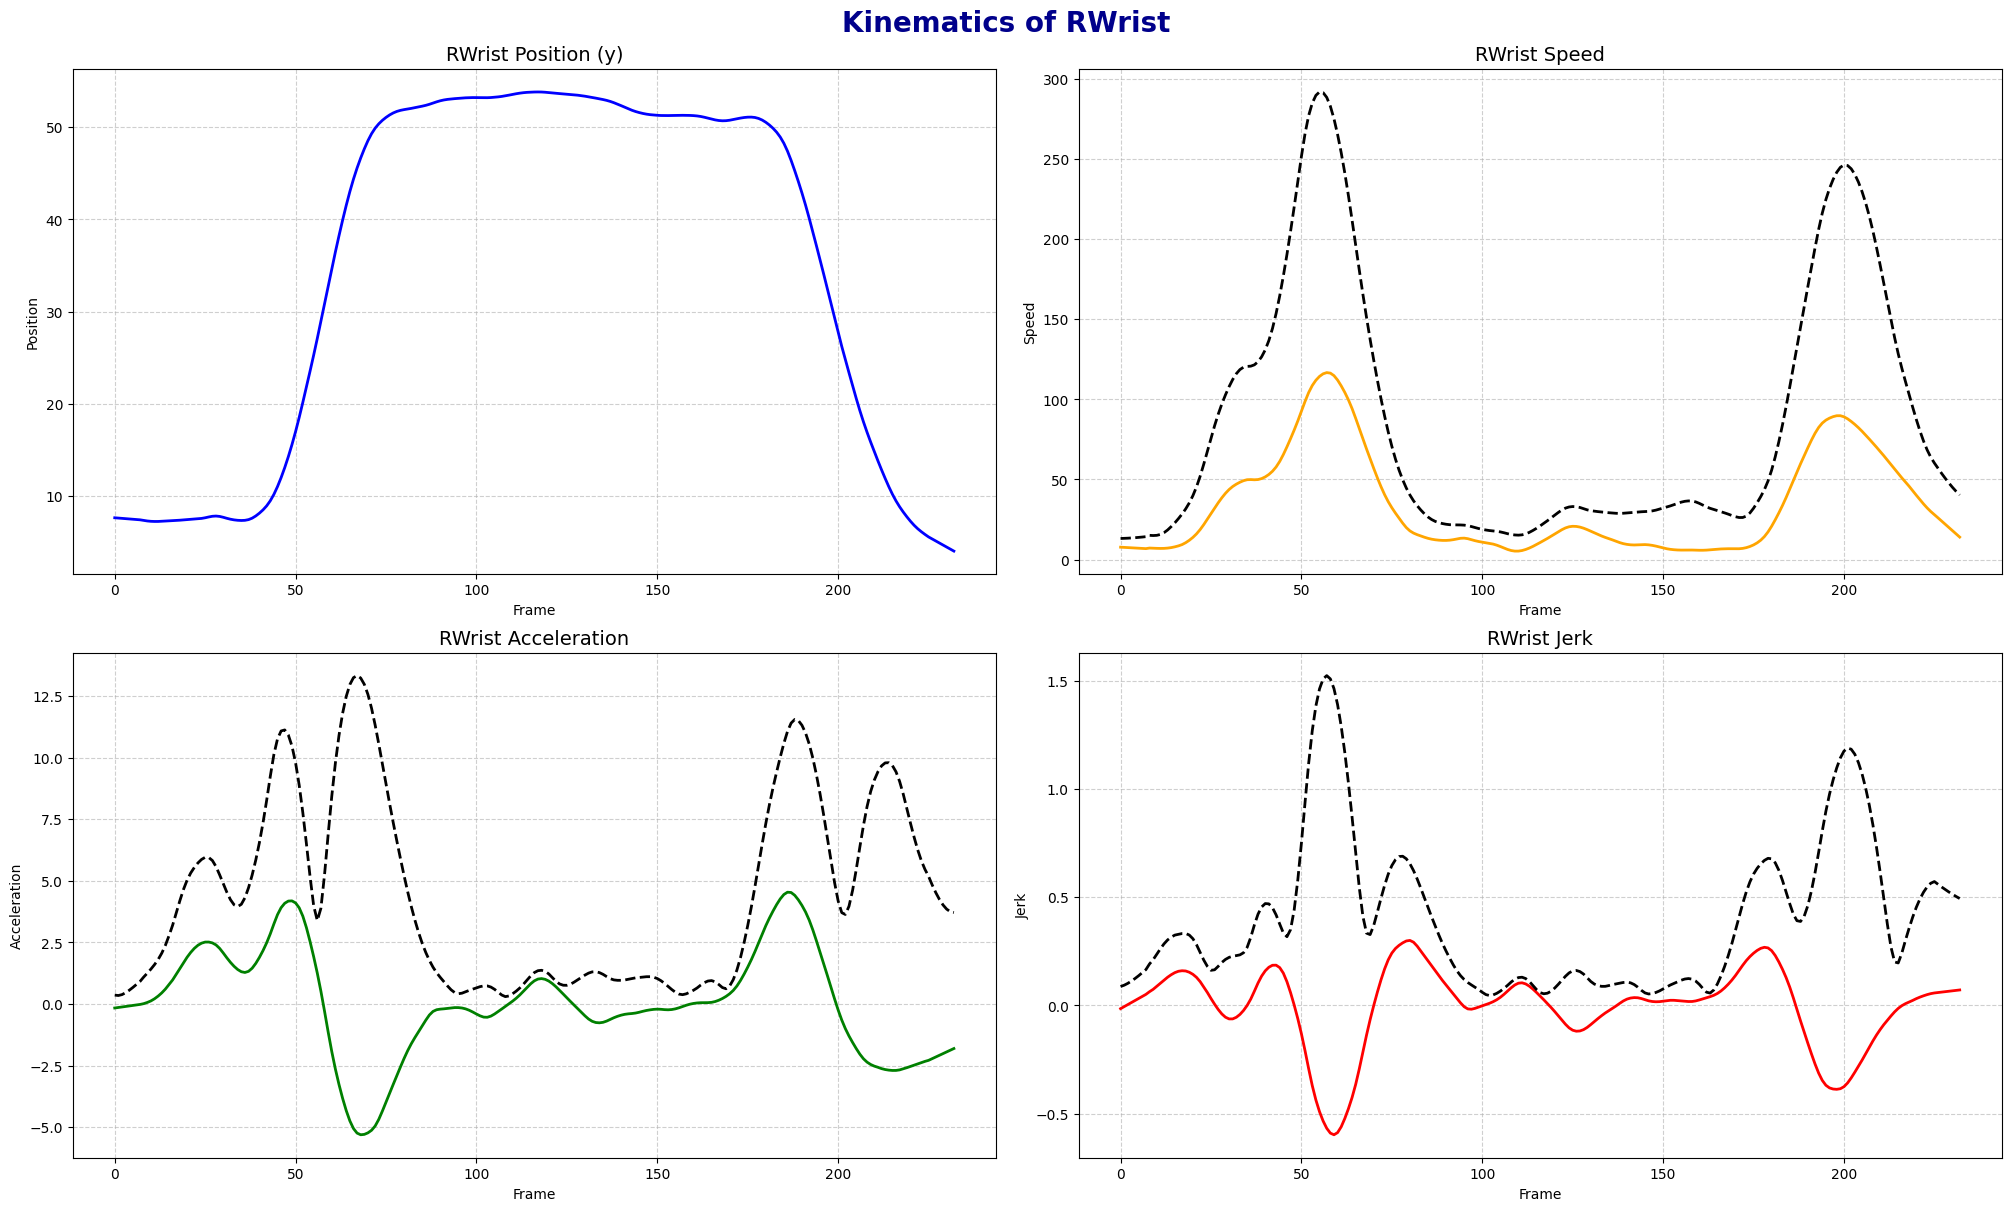

In [ ]:
#| echo: false

# Load one file to check
MTfiles = glob.glob(MTfolder_processed + '/*.csv')
print(MTfiles)
sample = pd.read_csv(MTfiles[4])

# Define colors and styles
colors = ['blue', 'orange', 'green', 'red']
titles = ['RWrist_y', 'RWrist_speed', 'RWrist_acc', 'RWrist_jerk']

# Create a 2x2 grid of plots
fig, axs = plt.subplots(2, 2, figsize=(20, 12), constrained_layout=True)
fig.suptitle('Kinematics of RWrist', fontsize=20, fontweight='bold', color='darkblue')

# Plot RWrist_y
axs[0, 0].plot(sample['RWrist_y'], color=colors[0], linewidth=2)
axs[0, 0].set_title('RWrist Position (y)', fontsize=14)
axs[0, 0].set_xlabel('Frame')
axs[0, 0].set_ylabel('Position')
axs[0, 0].grid(True, linestyle='--', alpha=0.6)

# Plot RWrist_speed
axs[0, 1].plot(sample['RWrist_speed'], color=colors[1], linewidth=2)
# add arm sum
axs[0, 1].plot(sample['arm_speedKin_sum'], color='black', linewidth=2, linestyle='--')
axs[0, 1].set_title('RWrist Speed', fontsize=14)
axs[0, 1].set_xlabel('Frame')
axs[0, 1].set_ylabel('Speed')
axs[0, 1].grid(True, linestyle='--', alpha=0.6)

# Plot RWrist_acc
axs[1, 0].plot(sample['RWrist_acc'], color=colors[2], linewidth=2)
# add arm sum
axs[1, 0].plot(sample['arm_accKin_sum'], color='black', linewidth=2, linestyle='--')
axs[1, 0].set_title('RWrist Acceleration', fontsize=14)
axs[1, 0].set_xlabel('Frame')
axs[1, 0].set_ylabel('Acceleration')
axs[1, 0].grid(True, linestyle='--', alpha=0.6)

# Plot RWrist_jerk
axs[1, 1].plot(sample['RWrist_jerk'], color=colors[3], linewidth=2)
# add arm sum
axs[1, 1].plot(sample['arm_jerkKin_sum'], color='black', linewidth=2, linestyle='--')
axs[1, 1].set_title('RWrist Jerk', fontsize=14)
axs[1, 1].set_xlabel('Frame')
axs[1, 1].set_ylabel('Jerk')
axs[1, 1].grid(True, linestyle='--', alpha=0.6)

# Adjust spacing
plt.subplots_adjust(hspace=0.3, wspace=0.3)

# Show the plot
plt.show()

# Motion processing - inverse kinematics

In the previous notebook, we have extracted joint angles using OpenSim (@ADDREF). Now again, we clean the data, smooth them (with 3rd order Savitzky-Golay filter to windows of ca. 240 ms), and extract further information before saving it into csv file per trial


We can once again check what would be the proper filter

In [12]:
#| code-fold: true
#| code-summary: Code to prepare environment

# get all mot files in the folder
mot_files = glob.glob(MTfolder + '*/P*/*/*.mot', recursive=True)
keypoints = ['wrist', 'pro_sup', 'elbow', 'arm', 'neck', 'subtalar', 'ankle', 'knee', 'hip', 'pelvis', 'L5_S1', 'L4_L5', 'L3_L4', 'L2_L3', 'L1_L2', 'L1_T12']

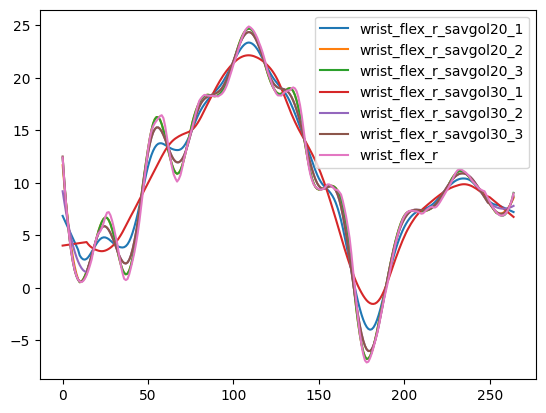

In [33]:
#| echo: false

sample = pd.read_csv(mot_files[20], sep='\t', skiprows=10)

windows = [20, 30] # list possible window
orders = [1, 2, 3] # list possible orders

check_smooth_strength(sample, windows, orders, 'wrist_flex_r')

We will apply a bit stronger filter of 1st order with span of 480 ms because the data are more noisy than the kinematics. For derivates, we will use the same filter as for kinematics (20, 3).

In [ ]:
#| eval: false

# get all mot files in the folder
mot_files = glob.glob(MTfolder + '*/P*/*/*.mot', recursive=True)
keypoints = ['wrist', 'pro_sup', 'elbow', 'arm', 'neck', 'subtalar', 'ankle', 'knee', 'hip', 'pelvis', 'L5_S1', 'L4_L5', 'L3_L4', 'L2_L3', 'L1_L2', 'L1_T12']

for mot in mot_files:
    # get trialid
    trialid = mot.split('\\')[-1].split('.')[0]
    print('working on ' + trialid)

    # get rid of the first element before _
    trialid = '_'.join(trialid.split('_')[1:])

    # load it
    mot_df = pd.read_csv(mot, sep='\t', skiprows=10)
    
    # pad 0 ms row
    padrow = mot_df.iloc[0].copy()
    padrow['time'] = 0

    # concatenate it to the beginning of mot_df
    mot_df = pd.concat([pd.DataFrame(padrow).T, mot_df], ignore_index=True)
    
    # get the sr
    sr = 1/np.mean(np.diff(mot_df['time']))

    ##### SMOOTHING ######

    # smooth all columns except the firts time (time) and last (trialid)
    colstosmooth = [x for x in mot_df.columns if 'time' not in x]

    # smooth
    for col in colstosmooth:
        mot_df[col] = scipy.signal.savgol_filter(mot_df[col], 30, 1)
        # convert to radians
        mot_df[col] = np.deg2rad(mot_df[col])

    # keep only columns you might use
    coi = [x for x in mot_df.columns if any(y in x for y in keypoints) or 'time' in x or 'TrialID' in x]
    mot_df2 = mot_df[coi]

    ##### DERIVATIVES ######

    # get derivatives
    mot_df2 = get_derivatives(mot_df2, sr, [], [], 'angles')

    #### AGGREGATING #####

    # aggregate data
    mot_df2 = aggregate_keypoints(mot_df2, 'speed', '_angSpeed_sum', 'angles')
    mot_df2 = aggregate_keypoints(mot_df2, 'acc', '_angAcc_sum', 'angles')
    mot_df2 = aggregate_keypoints(mot_df2, 'jerk', '_angJerk_sum', 'angles')

    # add time and trialid
    mot_df2['time'] = mot_df['time']
    # convert time to ms
    mot_df2['time'] = mot_df2['time']*1000
    mot_df2['TrialID'] = trialid

    # write to csv
    mot_df2.to_csv(MTfolder_processed + '/ik_' + trialid + '.csv', index=False)
    

working on e:\FLESH_ContinuousBodilyEffort\03_TS_processing\..\02_MotionTracking_processing\projectdata\Session_0_1\P0\ResultsInverseKinematics\0_0_1_0_p0.mot
working on e:\FLESH_ContinuousBodilyEffort\03_TS_processing\..\02_MotionTracking_processing\projectdata\Session_0_1\P0\ResultsInverseKinematics\0_0_1_3_p0.mot
working on e:\FLESH_ContinuousBodilyEffort\03_TS_processing\..\02_MotionTracking_processing\projectdata\Session_0_1\P0\ResultsInverseKinematics\0_0_1_4_p0.mot
working on e:\FLESH_ContinuousBodilyEffort\03_TS_processing\..\02_MotionTracking_processing\projectdata\Session_0_1\P0\ResultsInverseKinematics\0_0_1_5_p0.mot
working on e:\FLESH_ContinuousBodilyEffort\03_TS_processing\..\02_MotionTracking_processing\projectdata\Session_0_1\P0\ResultsInverseKinematics\0_0_1_6_p0.mot
working on e:\FLESH_ContinuousBodilyEffort\03_TS_processing\..\02_MotionTracking_processing\projectdata\Session_0_1\P0\ResultsInverseKinematics\0_0_1_7_p0.mot
working on e:\FLESH_ContinuousBodilyEffort\03_

,time,pelvis_tilt,pelvis_list,pelvis_rotation,pelvis_tx,pelvis_ty,pelvis_tz,hip_flexion_r,hip_adduction_r,hip_rotation_r,...,arm_angAcc_sum,pelvis_angAcc_sum,spine_angAcc_sum,lowerbody_angJerk_sum,leg_angJerk_sum,head_angJerk_sum,arm_angJerk_sum,pelvis_angJerk_sum,spine_angJerk_sum,TrialID
0,0.000,-0.482463,1.409259,-1.115839,0.004137,0.002900,0.002306,-0.024015,0.100460,-0.023562,...,0.226131,0.184704,0.010983,0.004709,0.001994,0.001490,0.018566,0.004538,0.000381,0_2_113_p1
1,16.667,-0.448263,1.408705,-1.152944,0.004136,0.002895,0.002311,-0.021531,0.091766,-0.026599,...,0.205296,0.182688,0.010820,0.002715,0.002275,0.001372,0.020040,0.002609,0.000328,0_2_113_p1
2,33.333,-0.416977,1.408287,-1.186825,0.004135,0.002891,0.002314,-0.018493,0.083700,-0.029738,...,0.186466,0.180673,0.010671,0.001090,0.002740,0.001271,0.021759,0.000788,0.000313,0_2_113_p1
3,50.000,-0.388710,1.408001,-1.217387,0.004134,0.002887,0.002316,-0.014979,0.076294,-0.032950,...,0.170306,0.178661,0.010536,0.001905,0.003311,0.001191,0.023671,0.001430,0.000342,0_2_113_p1
4,66.667,-0.363570,1.407839,-1.244534,0.004133,0.002884,0.002317,-0.011067,0.069581,-0.036208,...,0.157640,0.176650,0.010417,0.003833,0.003942,0.001135,0.025732,0.003328,0.000405,0_2_113_p1
5,83.333,-0.341661,1.407797,-1.268171,0.004131,0.002882,0.002317,-0.006833,0.063593,-0.039486,...,0.149359,0.174642,0.010314,0.005863,0.004610,0.001107,0.027909,0.005265,0.000490,0_2_113_p1
6,100.000,-0.323091,1.407869,-1.288203,0.004130,0.002881,0.002316,-0.002356,0.058362,-0.042754,...,0.146211,0.172636,0.010227,0.007918,0.005300,0.001111,0.030177,0.007209,0.000587,0_2_113_p1
7,116.667,-0.307965,1.408049,-1.304532,0.004128,0.002880,0.002314,0.002287,0.053920,-0.045987,...,0.148522,0.170632,0.010156,0.009981,0.006004,0.001145,0.032518,0.009156,0.000691,0_2_113_p1
8,133.333,-0.295099,1.408310,-1.318466,0.004126,0.002880,0.002312,0.007112,0.049971,-0.049270,...,0.160392,0.172288,0.010270,0.011685,0.006804,0.001252,0.035429,0.010728,0.000786,0_2_113_p1
9,150.000,-0.289492,1.408727,-1.324598,0.004124,0.002880,0.002309,0.011687,0.047792,-0.052143,...,0.169839,0.157297,0.009445,0.012421,0.007247,0.001308,0.035938,0.011359,0.000813,0_2_113_p1


Here is an example file

In [3]:
#| echo: false

motfiles = glob.glob(MTfolder_processed + '*.csv')
# Keep only ik_
motfiles = [x for x in motfiles if 'ik_' in x]
motfile = random.choice(motfiles)

# Display
mot = pd.read_csv(motfile)
mot.head(15)


,time,pelvis_tilt,pelvis_list,pelvis_rotation,pelvis_tx,pelvis_ty,pelvis_tz,hip_flexion_r,hip_adduction_r,hip_rotation_r,...,arm_angAcc_sum,pelvis_angAcc_sum,spine_angAcc_sum,lowerbody_angJerk_sum,leg_angJerk_sum,head_angJerk_sum,arm_angJerk_sum,pelvis_angJerk_sum,spine_angJerk_sum,TrialID
0,0.000,-0.983531,1.501698,-0.333585,0.004036,0.003443,0.001988,0.000335,0.095668,-0.009652,...,0.177075,0.617771,0.004946,0.028903,0.001225,0.001352,0.011940,0.028769,0.000711,0_2_48_p0
1,16.667,-1.110344,1.499345,-0.218769,0.004018,0.003486,0.001971,0.012108,0.098787,-0.006864,...,0.169079,0.627870,0.005347,0.022806,0.001385,0.001007,0.012110,0.022718,0.000661,0_2_48_p0
2,33.333,-1.227070,1.497084,-0.113788,0.004000,0.003526,0.001956,0.022712,0.101739,-0.004628,...,0.162284,0.637972,0.005792,0.016717,0.001649,0.000699,0.012609,0.016669,0.000611,0_2_48_p0
3,50.000,-1.333097,1.494931,-0.019147,0.003984,0.003561,0.001942,0.032110,0.104506,-0.002916,...,0.156844,0.648074,0.006273,0.010648,0.001976,0.000501,0.013399,0.010623,0.000562,0_2_48_p0
4,66.667,-1.427814,1.492903,0.064651,0.003970,0.003591,0.001929,0.040267,0.107072,-0.001700,...,0.152904,0.658177,0.006781,0.004681,0.002339,0.000547,0.014433,0.004597,0.000516,0_2_48_p0
5,83.333,-1.510610,1.491015,0.137101,0.003957,0.003617,0.001918,0.047146,0.109416,-0.000955,...,0.150583,0.668282,0.007311,0.002244,0.002723,0.000798,0.015663,0.001640,0.000471,0_2_48_p0
6,100.000,-1.580874,1.489284,0.197696,0.003946,0.003638,0.001909,0.052710,0.111522,-0.000651,...,0.149955,0.678387,0.007859,0.007922,0.003122,0.001123,0.017045,0.007585,0.000428,0_2_48_p0
7,116.667,-1.637996,1.487726,0.245933,0.003937,0.003654,0.001900,0.056925,0.113371,-0.000762,...,0.151042,0.688494,0.008420,0.013967,0.003530,0.001474,0.018547,0.013625,0.000389,0_2_48_p0
8,133.333,-1.686152,1.486267,0.285643,0.003928,0.003667,0.001893,0.060197,0.115062,-0.001155,...,0.157067,0.718139,0.009115,0.019127,0.004050,0.001819,0.020390,0.018737,0.000374,0_2_48_p0
9,150.000,-1.706583,1.485262,0.299887,0.003924,0.003669,0.001890,0.060806,0.116131,-0.002202,...,0.152841,0.690056,0.009273,0.022792,0.004374,0.002058,0.021333,0.022374,0.000343,0_2_48_p0


Here we can see the joint angle speed next to kinematic speed.

c:\Users\Sarka Kadava\Documents\Github\FLESH_ContinuousBodilyEffort\03_TS_processing\TS_motiontracking\ik_0_1_0_p0.csv
c:\Users\Sarka Kadava\Documents\Github\FLESH_ContinuousBodilyEffort\03_TS_processing\TS_motiontracking\mt_0_1_0_p0.csv


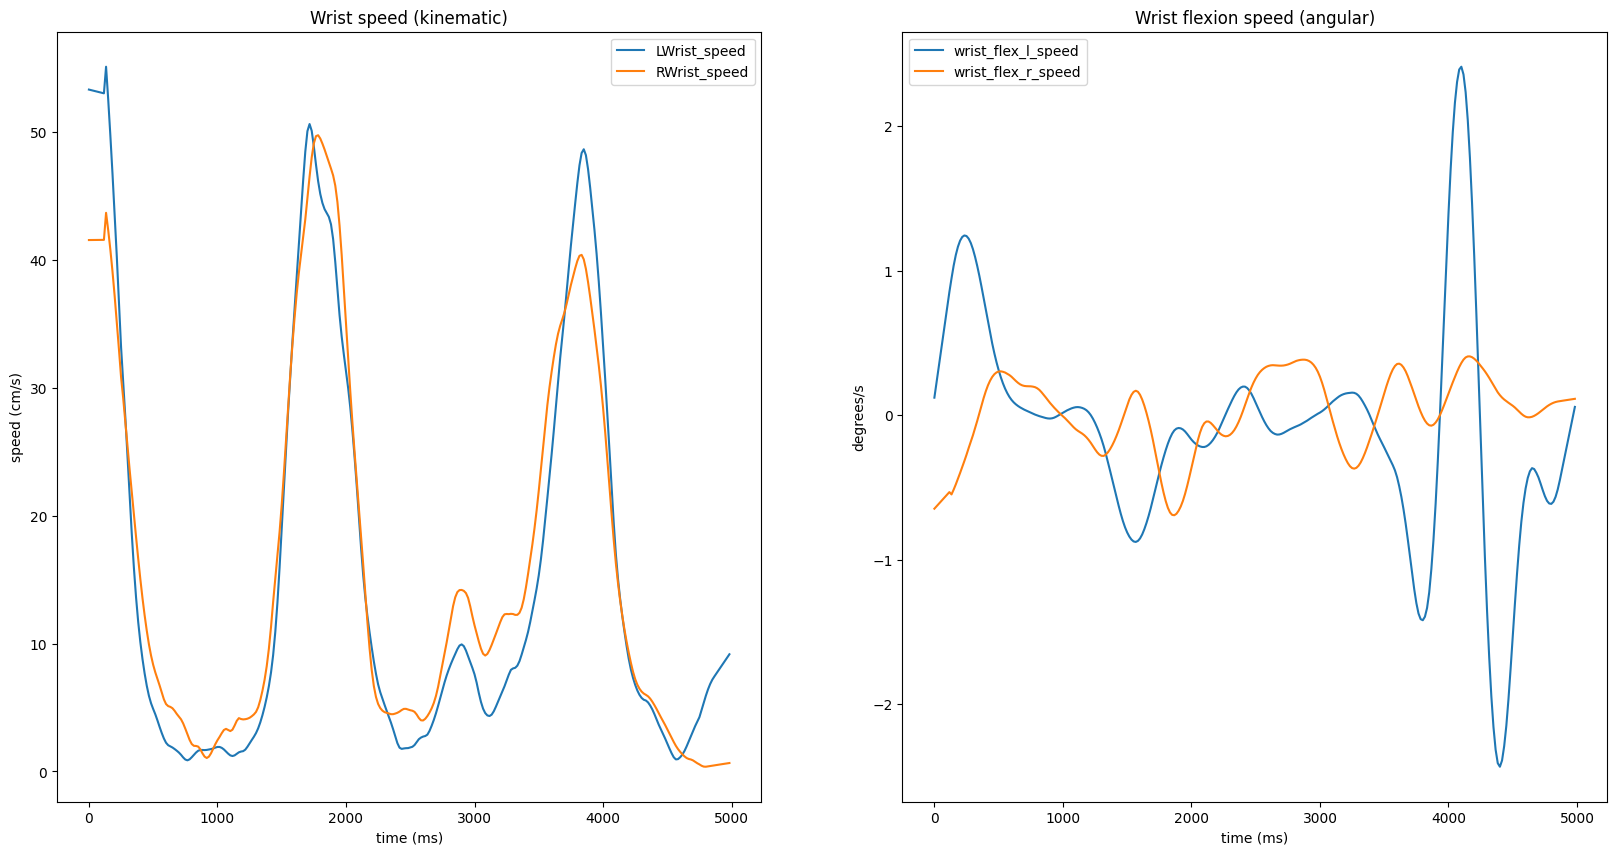

In [ ]:
#| echo: false

# load in one id and mt file with the same trialid
ikfiles = glob.glob(MTfolder_processed + '/ik*.csv')
mtfiles = glob.glob(MTfolder_processed + '/mt*.csv')

id = pd.read_csv(ikfiles[0])
mt = pd.read_csv(mtfiles[0])

# plot
fig, ax = plt.subplots(1, 2, figsize=(20, 10))

ax[0].plot(mt['Time'], mt['LWrist_speed'], label='LWrist_speed')
ax[0].plot(mt['Time'], mt['RWrist_speed'], label='RWrist_speed')
ax[0].set_title('Wrist speed (kinematic)')
ax[0].set_ylabel('speed (cm/s)')
ax[0].set_xlabel('time (ms)')
ax[0].legend()

# elbow flexion
ax[1].plot(id['time'], id['wrist_flex_l_speed'], label='wrist_flex_l_speed')
ax[1].plot(id['time'], id['wrist_flex_r_speed'], label='wrist_flex_r_speed')
ax[1].set_title('Wrist flexion speed (angular)')
ax[1].set_ylabel('rad/s')
ax[1].set_xlabel('time (ms)')
ax[1].legend()

plt.show()

# Motion processing - inverse dynamics

Now we do exactly the same also for inverse dynamics data (joint torques). 

In [40]:
#| code-fold: true
#| code-summary: Code to prepare environment

# in MTfolders, find all sto files
sto_files = glob.glob(MTfolder + '*/P*/*/*.sto', recursive=True)
sto_files = [x for x in sto_files if 'ID' in x]

Let's once again check the different smoothing strengths

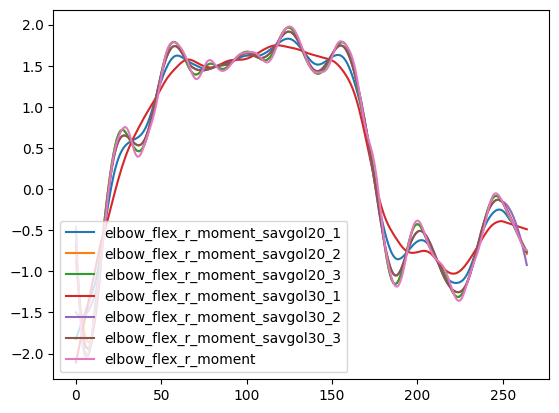

In [42]:
#| echo: false

sample = pd.read_csv(sto_files[20], sep='\t', skiprows=6)

windows = [20, 30] # list possible window
orders = [1, 2, 3] # list possible orders

check_smooth_strength(sample, windows, orders, 'elbow_flex_r_moment')

We will again reuse 1st order Savitzky-Golay filter with window of 480 ms for the moments. For first derivative (moment change) we again use the same filter as for kinematics (20, 3).

In [ ]:
#| eval: false

# in MTfolders, find all sto files
sto_files = glob.glob(MTfolder + '*/P*/*/*.sto', recursive=True)
sto_files = [x for x in sto_files if 'ID' in x]

for sto in sto_files:

    # from the filename, get the trialid
    trialid = sto.split('\\')[-1].split('.')[0]
    trialid = '_'.join(trialid.split('_')[:-1])
    trialid = '_'.join(trialid.split('_')[1:])

    print('working on ' + trialid)

    # load it
    id_df = pd.read_csv(sto, sep='\t', skiprows=6)

    # pad 0 ms row
    padrow = id_df.iloc[0].copy()
    padrow['time'] = 0

    # concatenate it to the beginning of id_df
    id_df = pd.concat([pd.DataFrame(padrow).T, id_df], ignore_index=True)

    ##### SMOOTHING #####

    # smooth all columns except the firts time (time) and last (trialid)
    colstosmooth = [x for x in id_df.columns if 'time' not in x]
    colstosmooth = [x for x in colstosmooth if 'TrialID' not in x]

    # smooth
    for col in colstosmooth:
        id_df[col] = scipy.signal.savgol_filter(id_df[col], 30, 1)

    ##### AGGREGATING #####

    # get aggregated euclidian sum for each joint group
    id_df = aggregate_keypoints(id_df, 'moment', '_moment_sum', 'angles')

    #### TORQUE CHANGE #####

    # for each moment col, we will also calculate the change 
    torquestodiff = [x for x in id_df.columns if 'moment' in x]

    for col in torquestodiff:
        torquechange = np.abs(np.insert(np.diff(id_df[col]), 0, 0))
        torquechange_smoothed = scipy.signal.savgol_filter(torquechange, 20, 3)
        # new data
        new_data = pd.DataFrame({col + '_change': torquechange_smoothed})
        id_df = pd.concat([id_df, new_data], axis=1)
    
    # convert time to ms
    id_df['time'] = id_df['time']*1000
        # add trialid
    id_df['TrialID'] = trialid

    # write to csv
    id_df.to_csv(MTfolder_processed + '/id_' + trialid + '.csv', index=False)

working on 0_1_0_p0


Here is an example file

In [46]:
#| echo: false

stofiles = glob.glob(MTfolder_processed + '*.csv')
# Keep only ik_
stofiles = [x for x in stofiles if 'id_' in x]
stofile = random.choice(stofiles)

# Display
sto = pd.read_csv(stofile)
sto.head(15)

,time,pelvis_tilt_moment,pelvis_list_moment,pelvis_rotation_moment,pelvis_tx_force,pelvis_ty_force,pelvis_tz_force,hip_flexion_r_moment,hip_adduction_r_moment,hip_rotation_r_moment,...,wrist_dev_r_moment_change,wrist_flex_l_moment_change,wrist_dev_l_moment_change,lowerbody_moment_sum_change,leg_moment_sum_change,head_moment_sum_change,arm_moment_sum_change,pelvis_moment_sum_change,spine_moment_sum_change,TrialID
0,0.000,-2.937909,34.356618,0.577621,1.496432,615.524822,1.666760,-41.127115,5.212768,0.475403,...,-0.000137,-0.000568,0.005876,0.725312,0.064328,0.072395,-0.015283,1.185869,0.436034,0_2_99_p1
1,16.544,-4.388108,31.225280,-0.887911,6.694879,614.907757,1.988157,-40.713289,5.527113,0.352445,...,0.000218,0.001068,0.009267,1.190040,0.176072,0.061213,0.044463,1.635017,0.634553,0_2_99_p1
2,33.210,-5.643683,28.525354,-2.159590,10.886014,614.437246,2.161209,-40.339111,5.881135,0.240178,...,0.000385,0.001611,0.010745,1.362125,0.226343,0.053173,0.073564,1.768805,0.702845,0_2_99_p1
3,49.876,-6.701583,26.271816,-3.235339,14.140210,614.103022,2.214570,-40.006645,6.258778,0.139196,...,0.000424,0.001453,0.010830,1.329595,0.232460,0.047239,0.080936,1.688879,0.681103,0_2_99_p1
4,66.542,-7.558755,24.479642,-4.113080,16.527839,613.894815,2.176895,-39.717959,6.643986,0.050092,...,0.000387,0.000933,0.009980,1.169195,0.209597,0.042620,0.074353,1.483178,0.604179,0_2_99_p1
5,83.208,-8.212149,23.163807,-4.790735,18.119275,613.802357,2.076838,-39.475116,7.020703,-0.026541,...,0.000319,0.000335,0.008593,0.946383,0.170783,0.038765,0.060448,1.225934,0.501589,0_2_99_p1
6,99.874,-8.658711,22.339286,-5.266228,18.984891,613.815380,1.943054,-39.280184,7.372873,-0.090108,...,0.000255,-0.000107,0.007006,0.715337,0.126906,0.035365,0.044712,0.977672,0.397506,0_2_99_p1
7,116.540,-8.895389,22.021057,-5.537480,19.195059,613.923615,1.804196,-39.135228,7.684440,-0.140016,...,0.000222,-0.000216,0.005495,0.518949,0.086708,0.032352,0.031494,0.785208,0.310766,0_2_99_p1
8,133.206,-8.954684,22.198905,-5.643946,19.155061,614.020221,1.622420,-39.019437,7.952600,-0.179548,...,0.000240,0.000133,0.004276,0.388829,0.056787,0.029899,0.024003,0.681652,0.254866,0_2_99_p1
9,149.872,-8.645692,23.207095,-5.390683,18.073907,614.238377,1.401536,-38.994531,8.104234,-0.190803,...,0.000319,0.001012,0.003503,0.345303,0.041600,0.028422,0.024304,0.686406,0.237962,0_2_99_p1


Now we can check by ploting the joint moment change against kinematic acceleration


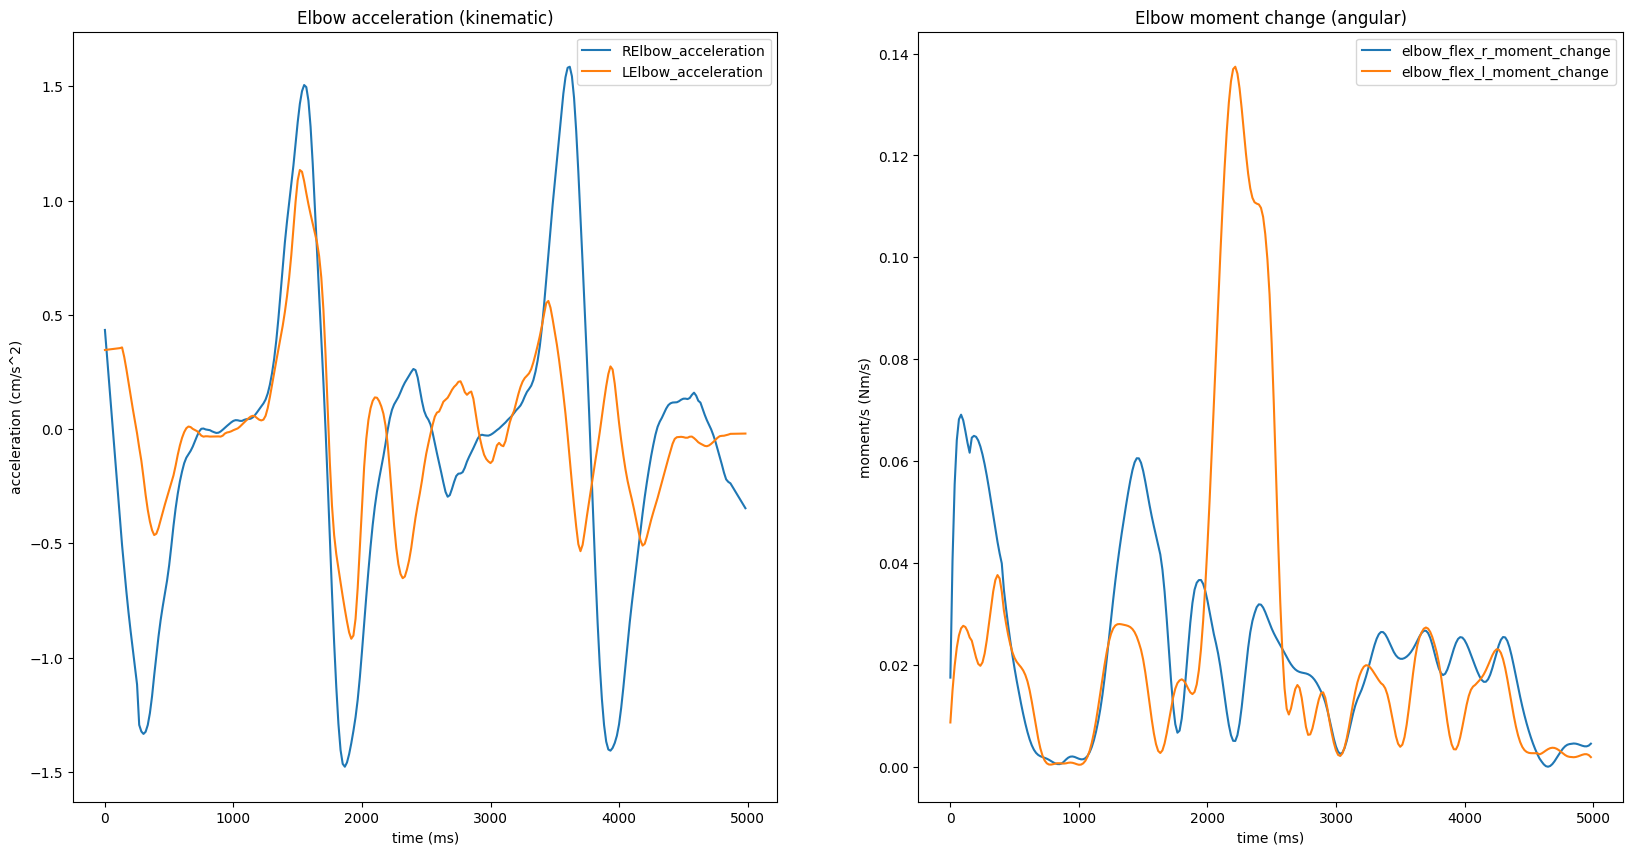

In [14]:
#| echo: false

# load in one id and mt file with the same trialid
idfiles = glob.glob(MTfolder_processed + '/id*.csv')
mtfiles = glob.glob(MTfolder_processed + '/mt*.csv')

id = pd.read_csv(idfiles[0])
mt = pd.read_csv(mtfiles[0])

# plot
fig, ax = plt.subplots(1, 2, figsize=(20, 10))

ax[0].plot(mt['Time'], mt['RElbow_acc'], label='RElbow_acceleration')
ax[0].plot(mt['Time'], mt['LElbow_acc'], label='LElbow_acceleration')
ax[0].set_title('Elbow acceleration (kinematic)')
ax[0].set_ylabel('acceleration (cm/s^2)')
ax[0].set_xlabel('time (ms)')
ax[0].legend()

# elbow flexion
ax[1].plot(id['time'], id['elbow_flex_r_moment_change'], label='elbow_flex_r_moment_change')
ax[1].plot(id['time'], id['elbow_flex_l_moment_change'], label='elbow_flex_l_moment_change')
ax[1].set_title('Elbow moment change (angular)')
ax[1].set_ylabel('moment/s (Nm/s)')
ax[1].set_xlabel('time (ms)')
ax[1].legend()

plt.show()

# Balance Board (Ground reaction forces) - processing

Lastly, we need to process the balance board data. We apply 5th order Savitzky-Golay filter to windows of 102 ms. To have a measure for postural adjustments, we compute the change in 2D magnitude (L2 norm of the center of pressure x and y) in center of pressure.

In [ ]:
#| eval: false

BB_files = glob.glob(BBfolder + '*BalanceBoard*.csv', recursive=True)

for bb in BB_files:
    # get trialid
    trialid = bb.split('\\')[-1].split('.')[0]
    # get the first, second, fourth, nineth elements
    trialid = '_'.join(trialid.split('_')[:2] + trialid.split('_')[3:4] + trialid.split('_')[8:9])

    print('working on ' + trialid)

    # because we are going to merge on bb, we will store also more information
    fileinfo = bb.split('\\')[-1].split('.')[0]

    # if second element is 1, we will store last three elements
    if fileinfo.split('_')[1] == '1':
        # if there is not 'corrected' in the name, we will store last three elements
        if 'corrected' not in fileinfo:
            info = '_'.join(fileinfo.split('_')[-3:])
        else:
            info = '_'.join(fileinfo.split('_')[-4:])
    elif fileinfo.split('_')[1] == '2':
        # otherwise we store last four elements (5 when corrected)
        if 'corrected' not in fileinfo:
            info = '_'.join(fileinfo.split('_')[-4:])
        else:
            info = '_'.join(fileinfo.split('_')[-5:])

    # Load the balanceboard data
    df_bb = pd.read_csv(bb)

    # Rename columns
    df_bb.columns = ['time_s', 'left_back', 'right_forward', 'right_back', 'left_forward']

    # Calculate sampling rate
    bbsamp = 1 / np.mean(np.diff(df_bb['time_s'] - min(df_bb['time_s'])))

    # Apply Savitzky-Golay filter to smooth the data
    for col in df_bb.columns[1:]:
        df_bb[col] = scipy.signal.savgol_filter(df_bb[col], 51, 5) # window of 102 ms

    # Calculate COPX and COPY
    COPX = (df_bb['right_forward'] + df_bb['right_back']) - (df_bb['left_forward'] + df_bb['left_back'])
    COPY = (df_bb['right_forward'] + df_bb['left_forward']) - (df_bb['left_back'] + df_bb['right_back'])

    # Calculate COPXc and COPYc 
    df_bb['COPXc'] = scipy.signal.savgol_filter(np.insert(np.diff(COPX), 0, 0), 51, 5) 
    df_bb['COPYc'] = scipy.signal.savgol_filter(np.insert(np.diff(COPY), 0, 0), 51, 5)

    # Calculate COPc
    df_bb['COPc'] = np.sqrt(df_bb['COPXc']**2 + df_bb['COPYc']**2)

    # restart the time so that starts from 0
    df_bb['time_s'] = df_bb['time_s'] - min(df_bb['time_s'])
    # convert to ms
    df_bb['time_s'] = df_bb['time_s']*1000

    # rename time_s to time
    df_bb.rename(columns={'time_s': 'time'}, inplace=True)

    # Add trialid
    df_bb['TrialID'] = trialid
    # Add info
    df_bb['FileInfo'] = info

    # Write as csv to MTfolder_processed
    df_bb.to_csv(MTfolder_processed + '/bb_' + trialid + '.csv', index=False)

Here is an example of a file

In [10]:
#| echo: false

bbfiles = glob.glob(MTfolder_processed + '*.csv')
# Keep only bb_
bbfiles = [x for x in bbfiles if 'bb_' in x]
bbfile = random.choice(bbfiles)

# Display
bb = pd.read_csv(bbfile)
bb.head(15)


,time,left_back,right_forward,right_back,left_forward,COPXc,COPYc,COPc,TrialID,FileInfo
0,0.000000,1.112750,0.828668,1.472466,1.410968,0.000387,-0.000076,0.000395,0_1_49_p1,p1_niet_gebaren
1,2.000052,1.112435,0.828515,1.472387,1.410450,0.000309,-0.000213,0.000375,0_1_49_p1,p1_niet_gebaren
2,4.000105,1.112227,0.828345,1.472341,1.410018,0.000238,-0.000315,0.000395,0_1_49_p1,p1_niet_gebaren
3,6.000157,1.112105,0.828164,1.472321,1.409660,0.000174,-0.000388,0.000425,0_1_49_p1,p1_niet_gebaren
4,8.000209,1.112054,0.827975,1.472321,1.409363,0.000117,-0.000435,0.000450,0_1_49_p1,p1_niet_gebaren
5,10.000262,1.112057,0.827784,1.472333,1.409117,0.000067,-0.000461,0.000466,0_1_49_p1,p1_niet_gebaren
6,12.000314,1.112102,0.827592,1.472351,1.408913,0.000023,-0.000469,0.000470,0_1_49_p1,p1_niet_gebaren
7,14.000366,1.112176,0.827404,1.472372,1.408743,-0.000014,-0.000463,0.000463,0_1_49_p1,p1_niet_gebaren
8,16.000418,1.112268,0.827220,1.472391,1.408598,-0.000045,-0.000445,0.000448,0_1_49_p1,p1_niet_gebaren
9,18.000471,1.112370,0.827043,1.472403,1.408473,-0.000070,-0.000419,0.000425,0_1_49_p1,p1_niet_gebaren


Here is an example of a timeseries representing change in center of pressure (COPc)

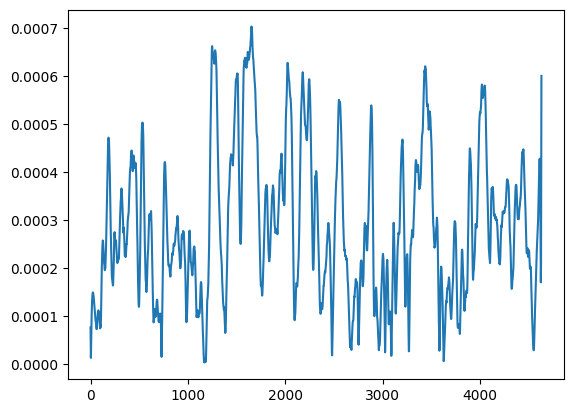

In [11]:
#| echo: false

bbfiles = glob.glob(MTfolder_processed + '/bb*.csv')
samplebb = pd.read_csv(bbfiles[20])

# plot COPc the sample
plt.plot(samplebb['time'], samplebb['COPc'])
#plt.xlim(1000,2000)
plt.show()